In [1]:
# coding:utf-8
"""
本篇主要为user_info()函数相关统计调试记录

"""
import pandas as pd
import numpy as np
from impala.dbapi import connect
from impala.util import as_pandas
import datetime as dt
import cPickle
import pymysql.cursors

In [2]:
# Global variables
mysql_host = '172.21.1.151'
mysql_port = 3306
mysql_user = 'xli'
mysql_password = '123456'
mysql_db = 'kdwtemp2'
mysql_charset = 'utf8mb4'

In [3]:
def easy_print(terms,tname, records=10): #逐条描述前五条记录，方便仔细查看表中值的特征
    conn = connect(host='172.21.1.120', port=21050, user='udms', database='kmi_month') 
    cur = conn.cursor()     
    
    sql = 'SELECT ' + terms + ' FROM ' + tname + ' LIMIT 5' 
    cur.execute(sql)
    read_in = as_pandas(cur)    
    cur.close()
    conn.close()
    
    #print in a format
    columns = read_in.columns.values
    values = read_in.values
    records = []
    for v in values:
        records.append(zip(columns, v))
    
    for ix,r in enumerate(records):
        print('----------第%s条记录--------' % (ix+1))
        for k, v in r:
            print('%s: %s' % (k, v))   

def full_print(terms,tname): #打出全表所选列，以方便进行统计查看规律，决定处理方法
    conn = connect(host='172.21.1.120', port=21050, user='udms', database='kmi_month') 
    cur = conn.cursor()     
    
    sql = 'SELECT ' + terms + ' FROM ' + tname
    cur.execute(sql)
    df = as_pandas(cur)
    print df
    cur.close()
    conn.close()

In [4]:
def encode_sex(data):
    if data == '男':
        return 1
    elif data == '女':
        return 2
    else:
        return 0

def abnormal_birth(data,fill_in_num):
    if data < 1940:
        return fill_in_num
    elif data > 2010:
        return fill_in_num
    else:
        return data
    
def cur_time_diff(data):
    cur_time = dt.datetime.now() 
    delta = cur_time - data
    return delta.days

def convert_time(data):
    data = pd.to_datetime(data, format='%Y-%m-%d %H:%M:%S')
    return data

In [5]:
def member_cache():
    conn = connect(host='172.21.1.120', port=21050, user='udms', database='kmi_month') 
    cur = conn.cursor()     
    
    # 1. wj_tbl_member_cache表中用户的有用信息
    sql = """SELECT kmid,birthday as member_birthday, sex as km_sex,
                accountcash,accountbalance,integralbalance,consumetotal,consumetimes,
                createcardtime,lastconsumetime FROM wj_tbl_member_cache"""
    cur.execute(sql)
    df = as_pandas(cur) 
    df = df.drop_duplicates(subset='kmid')
    #处理会员的性别编码
    df['km_sex'] = map(encode_sex, df['km_sex'])
    #处理会员的生日年份
    df['member_birthday'] = pd.to_datetime(df['member_birthday'], format='%Y-%m-%d')
    df['member_birthday'] = [i.year for i in df['member_birthday']]
    #处理会员生日异常值
    fill_in_num = int(df['member_birthday'].median())
    df['member_birthday'] = map(lambda x:abnormal_birth(x,fill_in_num), df['member_birthday'])
    #对卡创建时间和最后消费时间处理
    df['lastconsumetime'][df['lastconsumetime'] == 'null'] = df['createcardtime'][df['lastconsumetime'] == 'null']
    df['createcardtime'] = map(convert_time,df['createcardtime'])
    df['lastconsumetime'] = map(convert_time,df['lastconsumetime'])
    df['lastconsume_diff_create'] = df['lastconsumetime'] - df['createcardtime']
    df['lastconsume_diff_create_day'] = map(lambda x: x.days,df['lastconsume_diff_create'])
    df['lastconsume_diff_create_hour'] = map(lambda x: x.seconds/3600,df['lastconsume_diff_create'])
    df['lastconsume_diff_now'] = map(cur_time_diff,df['lastconsumetime'])
    drop_columns = ['lastconsume_diff_create','createcardtime','lastconsumetime']
    df.drop(drop_columns,axis=1,inplace=1)
    cur.close()
    conn.close()
    return df

# 1. member

In [6]:
member = member_cache()

D:\Users\Jialing Liao\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
member.shape[0] == member.drop_duplicates('kmid').shape[0]

True

In [8]:
member.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15559 entries, 0 to 15559
Data columns (total 11 columns):
kmid                            15559 non-null object
member_birthday                 15559 non-null int64
km_sex                          15559 non-null int64
accountcash                     15559 non-null object
accountbalance                  15559 non-null object
integralbalance                 15559 non-null object
consumetotal                    15559 non-null object
consumetimes                    15559 non-null object
lastconsume_diff_create_day     15559 non-null int64
lastconsume_diff_create_hour    15559 non-null int64
lastconsume_diff_now            15559 non-null int64
dtypes: int64(5), object(6)
memory usage: 1.4+ MB


In [9]:
member.head()

,kmid,member_birthday,km_sex,accountcash,accountbalance,integralbalance,consumetotal,consumetimes,lastconsume_diff_create_day,lastconsume_diff_create_hour,lastconsume_diff_now
0,000108491,1995,1,0.00,0.00,0.00,0.00,0,0,0,387
1,000108492,2000,1,120.00,120.00,0.00,180.00,1,0,0,387
2,000108494,1982,2,201.00,201.00,15.00,319.00,1,0,0,387
3,000108496,1986,2,15.00,15.00,485.00,1151.00,4,6,23,380
4,000108497,1981,1,0.00,0.00,16.00,1691.00,2,22,0,365


In [10]:
member.shape

(15559, 11)

In [11]:
def customer_openid():
    conn = connect(host='172.21.1.120', port=21050, user='udms', database='kmi_month') 
    cur = conn.cursor()    
    # 2. km_tbl_customer表中的有用信息
    sql1 = 'SELECT customerid,registertime,status as customer_status FROM km_tbl_customer'
    cur.execute(sql1)
    km_customer = as_pandas(cur)
    # status为0的为正常用户
    sql2 = 'SELECT openid,customerid FROM km_tbl_customer_openid_relation'
    cur.execute(sql2)
    openid = as_pandas(cur)
    temp = pd.merge(km_customer,openid,how='left',left_on='customerid',right_on='customerid')
    cur.close()
    conn.close()
    return temp

# 2. customer_openid  merge结果

In [12]:
customer_openid = customer_openid()

In [13]:
customer_openid.head()

,customerid,registertime,customer_status,openid
0,5792237,2016-05-01 00:00:00,0,NaN
1,5792238,2016-05-01 00:00:01,0,NaN
2,5792239,2016-05-01 00:00:05,0,NaN
3,5792240,2016-05-01 00:00:05,0,otCz6vsIe4jdqhe87w-tqsdDyMC4
4,5792241,2016-05-01 00:00:07,0,NaN


In [13]:
customer_openid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368275 entries, 0 to 368274
Data columns (total 4 columns):
customerid         368275 non-null object
registertime       368275 non-null object
customer_status    368275 non-null object
openid             103847 non-null object
dtypes: object(4)
memory usage: 14.0+ MB


In [14]:
customer_openid.shape

(368275, 4)

In [15]:
customer_openid.shape[0] == customer_openid.drop_duplicates('customerid').shape[0]

True

In [16]:
def wechat_info():
    conn = connect(host='172.21.1.120', port=21050, user='udms', database='kmi_month') 
    cur = conn.cursor()       
    # 3. kdw_tbl_kmwechat_userinfo表中的有用信息
    sql3 = """SELECT openid,
                    sex as wechat_sex,
                    city as wechat_city,
                    province as wechat_province,
                    country as wechat_country
              FROM kdw_tbl_kmwechat_userinfo"""
    cur.execute(sql3)
    wechat_info = as_pandas(cur)    
    cur.close()
    conn.close()
    return wechat_info

In [17]:
wechat_info = wechat_info()

In [18]:
wechat_info.drop_duplicates('openid',inplace=True)

In [19]:
wechat_info.head()

,openid,wechat_sex,wechat_city,wechat_province,wechat_country
0,otCz6vg--07eY8ZAoEBALjav6HMA,0,null,null,null
1,otCz6vg--3qEyiM2-Rd6TiL6twxc,0,null,null,null
2,otCz6vg--9OyO7I0QNenBsk3JQjs,2,张家口,河北,中国
3,otCz6vg--aHFpApYwsh0GseMnqVw,1,潮州,广东,中国
4,otCz6vg--BG--ZG7KkQrrDC8jNzc,1,浦东新区,上海,中国


In [20]:
wechat_info.shape

(1559362, 5)

In [21]:
wechat_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1559362 entries, 0 to 2160905
Data columns (total 5 columns):
openid             1559362 non-null object
wechat_sex         1559362 non-null object
wechat_city        1559362 non-null object
wechat_province    1559362 non-null object
wechat_country     1559362 non-null object
dtypes: object(5)
memory usage: 71.4+ MB


In [22]:
wechat_info.shape[0] == wechat_info.drop_duplicates('openid').shape[0]

True

In [23]:
customer_openid['openid'].notnull().sum()

103847

In [24]:
wechat_info['openid'].notnull().sum()

1559362

# 3. 合并wechat_info 和customerid_openid

In [25]:
temp = pd.merge(customer_openid,wechat_info,how='left',left_on='openid',right_on='openid')

In [26]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368275 entries, 0 to 368274
Data columns (total 8 columns):
customerid         368275 non-null object
registertime       368275 non-null object
customer_status    368275 non-null object
openid             103847 non-null object
wechat_sex         81738 non-null object
wechat_city        81738 non-null object
wechat_province    81738 non-null object
wechat_country     81738 non-null object
dtypes: object(8)
memory usage: 25.3+ MB


In [27]:
temp.shape[0] == temp.drop_duplicates('customerid').shape[0]

True

In [28]:
def wechat_userbind():
    conn = connect(host='172.21.1.120', port=21050, user='udms', database='kmi_month') 
    cur = conn.cursor()    
    # 4. wj_tbl_weixin_userbind表中的有用信息
    sql4 = 'SELECT openid,kmid,customerid FROM wj_tbl_weixin_userbind'
    cur.execute(sql4)
    wechat_userbind = as_pandas(cur)
    cur.close()
    conn.close
    return wechat_userbind

In [29]:
wechat_userbind = wechat_userbind()

In [30]:
wechat_userbind.shape

(112323, 3)

In [31]:
wechat_userbind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112323 entries, 0 to 112322
Data columns (total 3 columns):
openid        112323 non-null object
kmid          112323 non-null object
customerid    112323 non-null object
dtypes: object(3)
memory usage: 3.4+ MB


### 说明三者都有重复

In [32]:
len(pd.value_counts(wechat_userbind['openid']))

104950

In [33]:
len(pd.value_counts(wechat_userbind['kmid']))

109953

In [34]:
len(pd.value_counts(wechat_userbind['customerid']))

100283

In [35]:
wechat_userbind.drop_duplicates('openid',inplace=True)

In [36]:
wechat_userbind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104950 entries, 0 to 112321
Data columns (total 3 columns):
openid        104950 non-null object
kmid          104950 non-null object
customerid    104950 non-null object
dtypes: object(3)
memory usage: 3.2+ MB


In [37]:
len(pd.value_counts(wechat_userbind['kmid']))

104428

In [38]:
df_test = wechat_userbind.drop_duplicates('kmid')

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104428 entries, 0 to 112321
Data columns (total 3 columns):
openid        104428 non-null object
kmid          104428 non-null object
customerid    104428 non-null object
dtypes: object(3)
memory usage: 3.2+ MB


In [40]:
len(pd.value_counts(wechat_userbind['customerid']))

96783

In [41]:
df_test2 = df_test.drop_duplicates('customerid')

In [42]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96783 entries, 0 to 111830
Data columns (total 3 columns):
openid        96783 non-null object
kmid          96783 non-null object
customerid    96783 non-null object
dtypes: object(3)
memory usage: 3.0+ MB


### 以上测试说明按照三者分别去重可行，剩下的数据充足，为了后期表连成功，这里只好舍弃部分重复值

In [43]:
wechat_userbind.drop_duplicates('kmid',inplace=True)

In [44]:
wechat_userbind.drop_duplicates('customerid',inplace=True)

In [45]:
wechat_userbind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96783 entries, 0 to 111830
Data columns (total 3 columns):
openid        96783 non-null object
kmid          96783 non-null object
customerid    96783 non-null object
dtypes: object(3)
memory usage: 3.0+ MB


# 4. 合并上表与wechat_userbind

In [46]:
temp2 = pd.merge(temp,wechat_userbind,how='outer',left_on='openid',right_on='openid')

In [47]:
temp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464902 entries, 0 to 464901
Data columns (total 10 columns):
customerid_x       368275 non-null object
registertime       368275 non-null object
customer_status    368275 non-null object
openid             200474 non-null object
wechat_sex         81738 non-null object
wechat_city        81738 non-null object
wechat_province    81738 non-null object
wechat_country     81738 non-null object
kmid               96783 non-null object
customerid_y       96783 non-null object
dtypes: object(10)
memory usage: 39.0+ MB


In [48]:
temp2.head()

,customerid_x,registertime,customer_status,openid,wechat_sex,wechat_city,wechat_province,wechat_country,kmid,customerid_y
0,5792237,2016-05-01 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5792238,2016-05-01 00:00:01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5792239,2016-05-01 00:00:05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5792241,2016-05-01 00:00:07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5792242,2016-05-01 00:00:07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
temp2['customerid_x'].notnull().sum()

368275

In [50]:
len(temp2['customerid_x'].value_counts())

368275

In [51]:
temp2['customerid_y'].notnull().sum()

96783

In [52]:
len(temp2['customerid_y'].value_counts())

96783

### 不能drop customerid_y,因为只有它和kmid对应，然后它和customerid_x只重叠156个，drop掉后面只有156条有效信息

In [101]:
#temp2.drop('customerid_y',axis=1,inplace=True)

In [53]:
temp2['customerid_x'][temp2['customerid_x'].isnull()] = temp2['customerid_y']

In [54]:
temp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464902 entries, 0 to 464901
Data columns (total 10 columns):
customerid_x       464902 non-null object
registertime       368275 non-null object
customer_status    368275 non-null object
openid             200474 non-null object
wechat_sex         81738 non-null object
wechat_city        81738 non-null object
wechat_province    81738 non-null object
wechat_country     81738 non-null object
kmid               96783 non-null object
customerid_y       96783 non-null object
dtypes: object(10)
memory usage: 39.0+ MB


In [55]:
len(pd.value_counts(temp2['customerid_x']))

460276

In [56]:
df_test = temp2.drop_duplicates('customerid_x')

In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460276 entries, 0 to 464901
Data columns (total 10 columns):
customerid_x       460276 non-null object
registertime       368275 non-null object
customer_status    368275 non-null object
openid             195848 non-null object
wechat_sex         81738 non-null object
wechat_city        81738 non-null object
wechat_province    81738 non-null object
wechat_country     81738 non-null object
kmid               92157 non-null object
customerid_y       92157 non-null object
dtypes: object(10)
memory usage: 38.6+ MB


### 以上说明填充customerid以后去重可行

In [58]:
temp2.drop_duplicates('customerid_x',inplace=True)

In [59]:
temp2.drop('customerid_y',axis=1,inplace=True)

In [60]:
for i in temp2.columns:
    print i

customerid_x
registertime
customer_status
openid
wechat_sex
wechat_city
wechat_province
wechat_country
kmid


In [61]:
temp2.columns = ['customerid','registertime','customer_status','openid','wechat_sex','wechat_city','wechat_province','wechat_country','kmid']

In [62]:
temp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460276 entries, 0 to 464901
Data columns (total 9 columns):
customerid         460276 non-null object
registertime       368275 non-null object
customer_status    368275 non-null object
openid             195848 non-null object
wechat_sex         81738 non-null object
wechat_city        81738 non-null object
wechat_province    81738 non-null object
wechat_country     81738 non-null object
kmid               92157 non-null object
dtypes: object(9)
memory usage: 35.1+ MB


In [63]:
len(pd.value_counts(temp2['kmid']))==temp2.drop_duplicates('kmid').shape[0]-1

True

In [64]:
temp2['kmid'].notnull().sum()

92157

In [65]:
len(pd.value_counts(temp2['kmid']))

92157

# 5. 最后的合并（上表和member）

In [66]:
df = pd.merge(temp2,member,how='outer',left_on='kmid',right_on='kmid')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475776 entries, 0 to 475775
Data columns (total 19 columns):
customerid                      460276 non-null object
registertime                    368275 non-null object
customer_status                 368275 non-null object
openid                          195848 non-null object
wechat_sex                      81738 non-null object
wechat_city                     81738 non-null object
wechat_province                 81738 non-null object
wechat_country                  81738 non-null object
kmid                            107657 non-null object
member_birthday                 15559 non-null float64
km_sex                          15559 non-null float64
accountcash                     15559 non-null object
accountbalance                  15559 non-null object
integralbalance                 15559 non-null object
consumetotal                    15559 non-null object
consumetimes                    15559 non-null object
lastconsume_diff_c

In [68]:
df['openid'].notnull().sum() == df.drop_duplicates('openid').shape[0] - 1

True

### customerid,kmid,openid都没有重复，都有空值

In [69]:
len(pd.value_counts(df['customerid']))

460276

In [70]:
len(pd.value_counts(df['kmid']))

107657

In [71]:
len(pd.value_counts(df['openid']))

195848

In [72]:
df[df['customerid'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460276 entries, 0 to 460275
Data columns (total 19 columns):
customerid                      460276 non-null object
registertime                    368275 non-null object
customer_status                 368275 non-null object
openid                          195848 non-null object
wechat_sex                      81738 non-null object
wechat_city                     81738 non-null object
wechat_province                 81738 non-null object
wechat_country                  81738 non-null object
kmid                            92157 non-null object
member_birthday                 59 non-null float64
km_sex                          59 non-null float64
accountcash                     59 non-null object
accountbalance                  59 non-null object
integralbalance                 59 non-null object
consumetotal                    59 non-null object
consumetimes                    59 non-null object
lastconsume_diff_create_day     59 non-n

### 目测customerid和kmid都有的用户太少了，考虑用kmid填customerid的空缺

In [73]:
df['customerid'][df['customerid'].isnull()] = df['kmid']

D:\Users\Jialing Liao\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475776 entries, 0 to 475775
Data columns (total 19 columns):
customerid                      475776 non-null object
registertime                    368275 non-null object
customer_status                 368275 non-null object
openid                          195848 non-null object
wechat_sex                      81738 non-null object
wechat_city                     81738 non-null object
wechat_province                 81738 non-null object
wechat_country                  81738 non-null object
kmid                            107657 non-null object
member_birthday                 15559 non-null float64
km_sex                          15559 non-null float64
accountcash                     15559 non-null object
accountbalance                  15559 non-null object
integralbalance                 15559 non-null object
consumetotal                    15559 non-null object
consumetimes                    15559 non-null object
lastconsume_diff_c

### 这样customerid的空缺全部填上了,三个id都没有重复

In [75]:
len(pd.value_counts(df['customerid']))

475776

In [76]:
len(pd.value_counts(df['openid']))

195848

In [77]:
len(pd.value_counts(df['kmid']))

107657

# 写进数据库里

In [81]:
# conn = pymysql.connect(host=mysql_host,
#                                   port=mysql_port,
#                                   user=mysql_user,
#                                   password=mysql_password,
#                                   db=mysql_db,
#                                   charset=mysql_charset)
# cur = conn.cursor()
# sql = """CREATE TABLE `ljl_user_info1` (
#   `customerid` varchar(63) DEFAULT NULL,
#   `registertime` varchar(63) DEFAULT NULL,
#   `customer_status` varchar(63) DEFAULT NULL,
#   `openid` varchar(63) DEFAULT NULL,
#   `wechat_sex` varchar(63) DEFAULT NULL,
#   `wechat_city` varchar(63) DEFAULT NULL,
#   `wechat_province` varchar(63) DEFAULT NULL,
#   `wechat_country` varchar(63) DEFAULT NULL,
#   `kmid` varchar(63) DEFAULT NULL,
#   `member_birthday` double DEFAULT NULL,
#   `km_sex` double DEFAULT NULL,
#   `accountcash` varchar(63) DEFAULT NULL,
#   `accountbalance` varchar(63) DEFAULT NULL,
#   `integralbalance` varchar(63) DEFAULT NULL,
#   `consumetotal` varchar(63) DEFAULT NULL,
#   `consumetimes` varchar(63) DEFAULT NULL,
#   `lastconsume_diff_create_day` double DEFAULT NULL,
#   `lastconsume_diff_create_hour` double DEFAULT NULL,
#   `lastconsume_diff_now` double DEFAULT NULL
# ) ENGINE=InnoDB DEFAULT CHARSET=utf8
# """
# cur.execute(sql)
# conn.commit()
# cur.close()
# conn.close()

In [80]:
# conn = pymysql.connect(host=mysql_host,
#                                   port=mysql_port,
#                                   user=mysql_user,
#                                   password=mysql_password,
#                                   db=mysql_db,
#                                   charset=mysql_charset)
# cur = conn.cursor()
# sql = 'insert into ljl_user_info1()'

In [78]:
df.shape

(475776, 19)

In [79]:
conn = pymysql.connect(host=mysql_host,
                                  port=mysql_port,
                                  user=mysql_user,
                                  password=mysql_password,
                                  db=mysql_db,
                                  charset=mysql_charset)

df.to_sql(name="ljl_user_info", con=conn, flavor='mysql', if_exists='replace', chunksize=1000, index=False)
conn.close()

D:\Users\Jialing Liao\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\generic.py:1003: FutureWarning: The 'mysql' flavor with DBAPI connection is deprecated and will be removed in future versions. MySQL will be further supported with SQLAlchemy connectables.
  dtype=dtype)


In [2]:
df = user_info()

D:\Users\Jialing Liao\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 第三遍调试记录

## 1. wj_tbl_member_cache表中用户的有用信息

In [12]:
df.head()

,kmid,member_birthday,km_sex,accountcash,accountbalance,integralbalance,consumetotal,consumetimes,member_age_cut,lastconsume_diff_create_day,lastconsume_diff_create_hour,lastconsume_diff_now
0,000108491,1995,1,0.00,0.00,0.00,0.00,0,member_age_5,0,0,381
1,000108492,2000,1,120.00,120.00,0.00,180.00,1,member_age_6,0,0,381
2,000108494,1982,0,201.00,201.00,15.00,319.00,1,member_age_4,0,0,381
3,000108496,1986,0,15.00,15.00,485.00,1151.00,4,member_age_4,6,23,374
4,000108497,1981,1,0.00,0.00,16.00,1691.00,2,member_age_4,22,0,359


In [13]:
df.shape

(15559, 12)

In [14]:
df.columns

Index([u'kmid', u'member_birthday', u'km_sex', u'accountcash',
       u'accountbalance', u'integralbalance', u'consumetotal', u'consumetimes',
       u'member_age_cut', u'lastconsume_diff_create_day',
       u'lastconsume_diff_create_hour', u'lastconsume_diff_now'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15559 entries, 0 to 15559
Data columns (total 12 columns):
kmid                            15559 non-null object
member_birthday                 15559 non-null int64
km_sex                          15559 non-null int64
accountcash                     15559 non-null object
accountbalance                  15559 non-null object
integralbalance                 15559 non-null object
consumetotal                    15559 non-null object
consumetimes                    15559 non-null object
member_age_cut                  15559 non-null category
lastconsume_diff_create_day     15559 non-null int64
lastconsume_diff_create_hour    15559 non-null int64
lastconsume_diff_now            15559 non-null int64
dtypes: category(1), int64(5), object(6)
memory usage: 1.4+ MB


## 2. km_tbl_customer表中的有用信息

In [28]:
df.head()

,openid,customerid,registertime,customer_status
0,otCz6vlzsHIXM3XC9mV4mY3tWVIw,6104661,2016-05-28 12:00:48,0
1,otCz6vq5NUEmj2pTHlg4gk-il6zo,5792264,2016-05-01 00:00:57,0
2,otCz6vnjjdMtsq_e8J8xGmhy6oXU,5792283,2016-05-01 00:01:31,0
3,otCz6vnWgZq474ym9VApKzIs6yEg,5792250,2016-05-01 00:00:21,0
4,otCz6vgn9u8fKJFrsRl9eNnsGrTk,5792304,2016-05-01 00:02:32,0


In [29]:
df.shape

(103847, 4)

In [30]:
df.columns

Index([u'openid', u'customerid', u'registertime', u'customer_status'], dtype='object')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103847 entries, 0 to 103846
Data columns (total 4 columns):
openid             103847 non-null object
customerid         103847 non-null object
registertime       103847 non-null object
customer_status    103847 non-null object
dtypes: object(4)
memory usage: 4.0+ MB


## 3. kdw_tbl_kmwechat_userinfo表中的有用信息

In [35]:
df.head()

,openid,customerid,registertime,customer_status,wechat_sex,wechat_city,wechat_province,wechat_country
0,otCz6vlzsHIXM3XC9mV4mY3tWVIw,6104661,2016-05-28 12:00:48,0,1,,嘉义市,中国台湾
1,otCz6vlzsHIXM3XC9mV4mY3tWVIw,6104661,2016-05-28 12:00:48,0,1,,嘉义市,中国台湾
2,otCz6vq5NUEmj2pTHlg4gk-il6zo,5792264,2016-05-01 00:00:57,0,NaN,NaN,NaN,NaN
3,otCz6vnjjdMtsq_e8J8xGmhy6oXU,5792283,2016-05-01 00:01:31,0,2,深圳,广东,中国
4,otCz6vnjjdMtsq_e8J8xGmhy6oXU,5792283,2016-05-01 00:01:31,0,2,深圳,广东,中国


In [36]:
df.shape

(151744, 8)

In [37]:
df.columns

Index([u'openid', u'customerid', u'registertime', u'customer_status',
       u'wechat_sex', u'wechat_city', u'wechat_province', u'wechat_country'],
      dtype='object')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151744 entries, 0 to 151743
Data columns (total 8 columns):
openid             151744 non-null object
customerid         151744 non-null object
registertime       151744 non-null object
customer_status    151744 non-null object
wechat_sex         129635 non-null object
wechat_city        129635 non-null object
wechat_province    129635 non-null object
wechat_country     129635 non-null object
dtypes: object(8)
memory usage: 10.4+ MB


## 4. wj_tbl_weixin_userbind表中的有用信息

### wechat_bind有点问题 一探究竟

In [47]:
df.head()

,openid,kmid,customerid,wechat_bind_status
0,oil0uuDhkGzIvMUzskovynGhMA-g,057801433987345505122537,655278,2
1,oil0uuLwQyx0Yv6Lza48OAwSGDIw,000000001,2743853,2
2,oil0uuGtM6i8D9yFWqF1ceIzIxiw,000000002,0,1
3,oil0uuMWXypFWyb-Uer397vxs4p0,000000003,276619,2
4,oil0uuLQ3AnmC7zyDN9WcSaofLhI,000000004,104173,1


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112323 entries, 0 to 112322
Data columns (total 4 columns):
openid                112323 non-null object
kmid                  112323 non-null object
customerid            112323 non-null object
wechat_bind_status    112323 non-null object
dtypes: object(4)
memory usage: 4.3+ MB


In [49]:
df.shape

(112323, 4)

### left做表连以后

In [52]:
df.head()

,openid,kmid,customerid,wechat_bind_status,registertime,customer_status,wechat_sex,wechat_city,wechat_province,wechat_country
0,oil0uuDhkGzIvMUzskovynGhMA-g,057801433987345505122537,655278,2,NaN,NaN,NaN,NaN,NaN,NaN
1,oil0uuLwQyx0Yv6Lza48OAwSGDIw,000000001,2743853,2,NaN,NaN,NaN,NaN,NaN,NaN
2,oil0uuGtM6i8D9yFWqF1ceIzIxiw,000000002,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,oil0uuMWXypFWyb-Uer397vxs4p0,000000003,276619,2,NaN,NaN,NaN,NaN,NaN,NaN
4,oil0uuLQ3AnmC7zyDN9WcSaofLhI,000000004,104173,1,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df.shape

(112323, 10)

In [54]:
df.columns

Index([u'openid', u'kmid', u'customerid', u'wechat_bind_status',
       u'registertime', u'customer_status', u'wechat_sex', u'wechat_city',
       u'wechat_province', u'wechat_country'],
      dtype='object')

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112323 entries, 0 to 112322
Data columns (total 10 columns):
openid                112323 non-null object
kmid                  112323 non-null object
customerid            112323 non-null object
wechat_bind_status    112323 non-null object
registertime          0 non-null object
customer_status       0 non-null object
wechat_sex            0 non-null object
wechat_city           0 non-null object
wechat_province       0 non-null object
wechat_country        0 non-null object
dtypes: object(10)
memory usage: 9.4+ MB


### outer join

In [67]:
df.head()

,openid,kmid,customerid,registertime,customer_status,wechat_sex,wechat_city,wechat_province,wechat_country
0,oil0uuDhkGzIvMUzskovynGhMA-g,057801433987345505122537,655278,NaN,NaN,NaN,NaN,NaN,NaN
1,oil0uuLwQyx0Yv6Lza48OAwSGDIw,000000001,2743853,NaN,NaN,NaN,NaN,NaN,NaN
2,oil0uuLwQyx0Yv6Lza48OAwSGDIw,000000013,2743853,NaN,NaN,NaN,NaN,NaN,NaN
3,oil0uuGtM6i8D9yFWqF1ceIzIxiw,000000002,0,NaN,NaN,NaN,NaN,NaN,NaN
4,oil0uuMWXypFWyb-Uer397vxs4p0,000000003,276619,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df.shape

(264067, 9)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264067 entries, 0 to 264066
Data columns (total 9 columns):
openid             264067 non-null object
kmid               112323 non-null object
customerid         264067 non-null object
registertime       151744 non-null object
customer_status    151744 non-null object
wechat_sex         129635 non-null object
wechat_city        129635 non-null object
wechat_province    129635 non-null object
wechat_country     129635 non-null object
dtypes: object(9)
memory usage: 20.1+ MB


In [71]:
df.columns

Index([u'openid', u'kmid', u'customerid', u'registertime', u'customer_status',
       u'wechat_sex', u'wechat_city', u'wechat_province', u'wechat_country'],
      dtype='object')

## 5. merge全部表

In [74]:
df.head()

,kmid,member_birthday,km_sex,accountcash,accountbalance,integralbalance,consumetotal,consumetimes,member_age_cut,lastconsume_diff_create_day,lastconsume_diff_create_hour,lastconsume_diff_now,openid,customerid,registertime,customer_status,wechat_sex,wechat_city,wechat_province,wechat_country
0,000108491,1995,1,0.00,0.00,0.00,0.00,0,member_age_5,0,0,381,oY2rcsvnlXRwxPUVUX2a_sjoZb54,4721830,NaN,NaN,NaN,NaN,NaN,NaN
1,000108492,2000,1,120.00,120.00,0.00,180.00,1,member_age_6,0,0,381,oYKurwj7gcmDGqUPDlDu8uA08Ark,5795483,NaN,NaN,NaN,NaN,NaN,NaN
2,000108494,1982,0,201.00,201.00,15.00,319.00,1,member_age_4,0,0,381,oYKurwgr5VmyQb21VZ_hqzLaPwzM,5795484,NaN,NaN,NaN,NaN,NaN,NaN
3,000108496,1986,0,15.00,15.00,485.00,1151.00,4,member_age_4,6,23,374,oY2rcshR6wIsAWlHe-6wGUGVvlec,5795486,NaN,NaN,NaN,NaN,NaN,NaN
4,000108497,1981,1,0.00,0.00,16.00,1691.00,2,member_age_4,22,0,359,osKIrt9ibvrtogGeakQXrncbvssg,5795487,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
df.shape

(273398, 20)

In [76]:
df.columns

Index([u'kmid', u'member_birthday', u'km_sex', u'accountcash',
       u'accountbalance', u'integralbalance', u'consumetotal', u'consumetimes',
       u'member_age_cut', u'lastconsume_diff_create_day',
       u'lastconsume_diff_create_hour', u'lastconsume_diff_now', u'openid',
       u'customerid', u'registertime', u'customer_status', u'wechat_sex',
       u'wechat_city', u'wechat_province', u'wechat_country'],
      dtype='object')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273398 entries, 0 to 273397
Data columns (total 20 columns):
kmid                            121654 non-null object
member_birthday                 15559 non-null float64
km_sex                          15559 non-null float64
accountcash                     15559 non-null object
accountbalance                  15559 non-null object
integralbalance                 15559 non-null object
consumetotal                    15559 non-null object
consumetimes                    15559 non-null object
member_age_cut                  15559 non-null object
lastconsume_diff_create_day     15559 non-null float64
lastconsume_diff_create_hour    15559 non-null float64
lastconsume_diff_now            15559 non-null float64
openid                          264067 non-null object
customerid                      264067 non-null object
registertime                    151744 non-null object
customer_status                 151744 non-null object
wechat_sex     

In [4]:
pd.value_counts(df['customerid'])

0          2722
5948383      54
2743853      52
5819210      40
6139758      38
5964123      37
5913691      33
5832917      32
6100975      32
5964124      31
6025160      31
6163558      31
5959305      30
5963498      29
5824681      28
6141710      28
6036321      28
5958543      28
5957265      28
5880864      28
6136719      28
6074937      27
6141661      27
6153093      27
5848549      26
5914782      26
5996762      26
5964121      26
6118779      24
6045179      24
           ... 
6042291       1
6152907       1
6152906       1
6152905       1
6152904       1
1305470       1
5727285       1
5963133       1
4480146       1
4474580       1
5697265       1
4771862       1
4152599       1
5819828       1
4675704       1
5569629       1
5849267       1
5849265       1
6103872       1
5841478       1
5963138       1
4672481       1
5841472       1
5841471       1
5841470       1
5841477       1
5841476       1
5841475       1
5841474       1
5533177       1
Name: customerid, dtype:

In [77]:
for i in df.columns:
    print i + "  "

kmid  
member_birthday  
km_sex  
accountcash  
accountbalance  
integralbalance  
consumetotal  
consumetimes  
member_age_cut  
lastconsume_diff_create_day  
lastconsume_diff_create_hour  
lastconsume_diff_now  
openid  
customerid  
registertime  
customer_status  
wechat_sex  
wechat_city  
wechat_province  
wechat_country  


# 0. 第一遍编写调试记录

## 决定放弃使用wj_tbl_member_cache表的papertype和papernumber两个属性

### 证件类型中学生证太少，不足以用以判断用户是不是学生

In [9]:
pd.value_counts(df['papertype'])

身份证    14798
         757
学生证        3
???        1
Name: papertype, dtype: int64

### 有身份证号数的数据也太少了，用于提取生日获取年龄信息比较困难

In [10]:
pd.value_counts(df['papernumber'])

                       15129
邓先生                        2
15043019961017423X         1
51622199601037742          1
362523199304055219         1
19921024                   1
5109231198309104626        1
00001690                   1
340321199503101549         1
6528272001050323           1
430304199204022053         1
21011199401312529          1
360424199003112848         1
15041200009010030          1
330327198709201993         1
441426198708200636         1
430219197704105429         1
370686199603160044         1
371002198612033051         1
430302199501094536         1
140524198605137030         1
43030200001010415          1
432503198311162029         1
36232219930916031x         1
430181198910056418         1
652823198901092625         1
32022297812150019          1
230281199011194625         1
150422199710062729         1
430304198911223052         1
                       ...  
150403199307272516         1
352202198906134518         1
王琴                         1
43032119900412

In [30]:
pd.value_counts(df['lastconsumetime'])

null                   1059
2016-05-23 21:50:34       2
2016-05-27 23:16:40       2
2016-05-12 09:48:58       2
2016-05-31 21:49:36       2
2016-05-31 21:13:33       2
2016-05-16 23:11:09       2
2016-05-21 21:40:00       2
2016-05-30 22:23:57       2
2016-05-28 22:12:01       2
2016-05-21 21:28:50       2
2016-05-28 14:48:42       2
2016-05-22 21:59:11       2
2016-03-29 20:22:33       2
2016-05-30 21:12:15       2
2016-05-21 22:31:22       2
2016-05-26 20:30:08       2
2016-05-07 21:05:08       2
2016-05-07 21:24:51       2
2016-01-12 20:33:07       2
2016-05-14 22:25:15       2
2016-05-14 21:53:45       2
2016-05-01 23:20:58       2
2016-05-30 22:20:19       2
2016-05-19 22:24:06       2
2016-05-14 21:07:21       2
2016-05-14 21:07:47       2
2016-05-27 23:51:01       2
2016-05-05 22:20:24       2
2016-05-30 22:07:34       2
                       ... 
2016-05-22 23:49:18       1
2016-05-07 01:58:15       1
2016-05-14 12:17:39       1
2016-01-10 19:58:06       1
2016-05-14 22:18:23 

In [19]:
df.sort_values('lastconsumetime', ascending=False)

,kmid,member_birthday,member_sex,accountcash,accountbalance,integralbalance,consumetotal,consumetimes,createcardtime,lastconsumetime,member_age_cut
7779,000115824,1988,0,0.00,0.00,0.00,0.00,0,2016-05-13 17:20:12,null,member_age_5
8685,000117270,1988,0,0.00,0.00,0.00,0.00,0,2016-05-14 23:56:12,null,member_age_5
8710,000117307,1993,1,0.00,0.00,0.00,0.00,0,2016-05-15 01:11:09,null,member_age_5
8718,000117321,1993,0,0.00,0.00,0.00,0.00,0,2016-05-15 02:10:15,null,member_age_5
8725,000117331,1995,0,0.00,0.00,0.00,0.00,0,2016-05-15 05:26:06,null,member_age_5
8728,000117338,1991,1,0.00,0.00,0.00,0.00,0,2016-05-15 09:31:42,null,member_age_5
8729,000117341,1989,0,0.00,0.00,0.00,0.00,0,2016-05-15 10:10:21,null,member_age_5
8731,000117346,1983,1,0.00,0.00,0.00,0.00,0,2016-05-15 10:59:31,null,member_age_4
8732,000117349,2000,1,0.00,0.00,0.00,0.00,0,2016-05-15 11:07:15,null,member_age_6
8733,000117350,1987,1,0.00,0.00,0.00,0.00,0,2016-05-15 11:08:21,null,member_age_4


### 加入代码用对应createcardtime填充lastconsumetime缺失值后

In [42]:
df.sort_values('lastconsumetime', ascending=False)

,kmid,member_birthday,km_sex,accountcash,accountbalance,integralbalance,consumetotal,consumetimes,createcardtime,lastconsumetime,member_age_cut,lastconsume_diff_now
14477,000129618,1993,1,174.00,174.00,25.00,126.00,2,2016-05-29 15:13:00,2016-06-02 04:21:17,member_age_5,344
9038,000117849,1986,1,740.00,740.00,38.00,860.00,15,2016-05-15 22:11:53,2016-06-02 04:01:19,member_age_4,344
12264,000129549,1993,0,15.00,15.00,56.00,285.00,4,2016-05-23 16:16:12,2016-06-02 02:44:58,member_age_5,344
895,000109857,1989,0,0.00,0.00,51.00,1089.00,8,2016-05-02 21:44:11,2016-06-02 02:37:34,member_age_5,344
13257,000124913,1985,0,435.00,435.00,120.00,2465.00,15,2016-05-26 21:29:59,2016-06-02 02:33:17,member_age_4,344
14197,000126475,1985,1,362.00,362.00,67.00,1438.00,12,2016-05-28 22:11:35,2016-06-02 02:09:35,member_age_4,344
12239,000128056,1993,0,34.00,34.00,52.00,266.00,3,2016-05-23 15:43:03,2016-06-02 02:04:47,member_age_5,344
9626,000118827,1991,1,879.00,1151.00,110.00,1449.00,5,2016-05-17 20:50:45,2016-06-02 02:01:51,member_age_5,344
7802,000129551,1993,-1,10.00,10.00,2590.00,2590.00,3,2016-05-13 18:21:36,2016-06-02 01:49:02,member_age_5,344
8813,000125548,1993,1,88.00,88.00,42.00,212.00,2,2016-05-15 15:31:41,2016-06-02 01:45:08,member_age_5,344


## kmid去重成功

In [150]:
pd.value_counts(df['kmid'])

000063919    1
000121889    1
000123020    1
000123021    1
000123022    1
000119053    1
000123024    1
000123025    1
000119056    1
000123027    1
000119058    1
000111236    1
000119504    1
000127592    1
000119502    1
000119500    1
000119501    1
000122813    1
000113353    1
000051429    1
000122810    1
000051350    1
000051351    1
000121880    1
000126807    1
000111231    1
000121885    1
000121886    1
000117076    1
000118902    1
            ..
000115810    1
000119312    1
000121638    1
000119311    1
000123180    1
000127743    1
000127745    1
000127744    1
000119319    1
000123188    1
000044348    1
000125327    1
000066620    1
000126651    1
000066624    1
000121637    1
000123452    1
000121636    1
000110545    1
000126650    1
000121630    1
000050545    1
000123459    1
000126653    1
000123455    1
000123457    1
000123451    1
000123450    1
000123453    1
000122891    1
Name: kmid, dtype: int64

In [119]:
pd.get_dummies(df['member_sex'])

,,保,女,男
0,0,0,0,1
1,0,0,0,1
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1
5,0,0,0,1
6,0,0,0,1
7,0,0,1,0
8,0,0,0,1
9,0,0,0,1


In [165]:
pd.value_counts(df['member_birthday'])

1993    2788
2000    1116
1995     822
1990     791
1994     788
1996     751
1997     731
1992     718
1991     703
1989     673
1988     615
1998     586
1987     540
1986     472
1999     351
1985     350
1983     285
1982     265
1984     246
1981     245
1980     188
1979     154
1978     146
1977     131
1976     104
1975     101
1974      93
1973      79
2001      78
1972      74
        ... 
2003      25
1964      23
1963      21
1966      20
1961      17
1962      16
1960      11
1959      11
1956       9
2004       8
2010       8
2005       7
2008       7
1953       6
1958       6
1957       5
1949       5
1955       5
2006       4
1950       4
1947       3
1952       3
2009       3
1951       2
1954       2
2007       1
1946       1
1942       1
1943       1
1944       1
Name: member_birthday, dtype: int64

## 对K米会员的生日进行统计画图

<Container object of 87 artists>

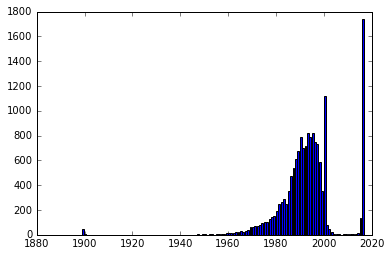

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt

count_by_age = pd.value_counts(df['member_birthday'])
index = count_by_age.index.values
values = count_by_age.values
plt.bar(index, values)

### 可以看出接近1900年和接近2016年的数据都是异常值，要替换掉

In [152]:
df['member_birthday'].mode()

0    2016
dtype: int64

### 众数不能用，用中位数填充合理

In [155]:
int(df['member_birthday'].median())

1993